## Curve fiting of proteins by dose 

In order to start plotting the curves, we made some modifications to the dose values:  

- we transformed the doses to a logarithmic scale: `dose_log <- log10(dose)`  
- we set the dose spacing to 1: `dose_spacing = 1`  
- we shifted the dose values to ensure all were positive:  
  `dose_shift = abs(min(dose_log)) + dose_spacing`  
- finally, we applied the shift: `dose_log_shifted <- dose_log + dose_shift`  

We then used the **fastbmdR** package on our **norm_signal** data, after filtering out proteins that had 100% missing values.

In [1]:
#
library(ggplot2)

#install.packages("drc", dependencies = TRUE)

devtools::install_github("jessica-ewald/fastbmdR")


Using GitHub PAT from the git credential store.

Skipping install of 'fastbmdR' from a github remote, the SHA1 (b3681861) has not changed since last install.
  Use `force = TRUE` to force installation



In [2]:
library(fastbmdR)
library(dplyr)
library(knitr)


Attachement du package : 'dplyr'


Les objets suivants sont masqu'es depuis 'package:stats':

    filter, lag


Les objets suivants sont masqu'es depuis 'package:base':

    intersect, setdiff, setequal, union




In [21]:
df <- read.csv("./outputs/norm_signal_filtered.csv", sep= ',')


models <- c("Exp2", "Exp3", "Exp4", "Exp5", "Poly2", "Lin", "Power", "Hill")

ncpus <- 1  

unique_compounds <- setdiff(unique(df$Metadata_Compound), c("UNTREATED"))
feat_cols =colnames(df)[!grepl("Metadata", colnames(df))]
res = list()
gene_table <- list()

for (compound in unique_compounds) 
{
  compound_dt <- df[df$Metadata_Compound == compound, ]
  dmso_data <- df[df$Metadata_Compound == "DMSO", ]
  dmso_dose <- dmso_data$Metadata_Concentration

  dose <- compound_dt$Metadata_Concentration
  dose_log <- log10(dose)
  dose_spacing = 1
  dose_shift = abs(min(dose_log)) + dose_spacing

  dose_log_shifted <- dose_log + dose_shift
  dose_log_shifted_with_dmso <- c(dose_log_shifted, dmso_dose)
  compound_data <- df[df$Metadata_Compound == compound | df$Metadata_Compound == "DMSO", ]

  if (length(unique(compound_data$Metadata_Concentration)) > 2) 
  {  
    
    print(paste("Processing compound:", compound))
    dose <- dose_log_shifted_with_dmso
    
    compound_mat <- compound_data[, feat_cols]  
    compound_mat = t(compound_mat)  
    
    min_val = abs(min(compound_mat, na.rm=TRUE))  
    add_min = min_val + 0.1 * min_val  
    mat_new = compound_mat + add_min  

    
    if (length(dose) == ncol(mat_new)) {  
      tryCatch({
 
        fit_obj <- PerformCurveFitting(data = mat_new, dose = dose, ncpus = ncpus, models = models)
        
        fit_obj <- FilterDRFit(fit_obj, lof.pval = 0.1, filt.var = "AIC.model")
        

        fit_obj <- PerformBMDCalc(fit_obj, ncpus = ncpus, num.sds = 2, bmr.method = "sample.mean", log10.dose = TRUE)
        

        bmd_res <- fit_obj$bmd_res
        bmd_pass <- bmd_res[bmd_res$all.pass, ]
        fit_obj$bmd_pass <- bmd_pass

        res[[compound]] = fit_obj
        
        gene_ids <- res[[compound]][["bmd_pass"]][["gene.id"]]
        bmd_values <- res[[compound]][["bmd_pass"]][["bmd"]]
        bmd_l <- res[[compound]][["bmd_pass"]][["bmdl"]]
        bmd_u <- res[[compound]][["bmd_pass"]][["bmdu"]]
        gene_table[[compound]] <- data.frame(
          gene_id = gene_ids,
          bmd_value = bmd_values,
          bmd_l = bmd_l,
          bmd_u = bmd_u
        )
        
        
        #plot_bmd_curve("O00175", res$compound)
        
        #print(paste("Results for compound:", compound))
        #print(bmd_pass)
        
      }, error = function(e) {
        
        print(paste("Error with compound:", compound, "- ignoring this compound"))
      })
    }
  }  
}



[1] "Processing compound: Actinomycin D"
[1] "Processing compound: Bevirimat"
[1] "Processing compound: Ethoxyquin"
[1] "Processing compound: Amperozide"
[1] "Processing compound: IOPANOIC ACID"
[1] "Processing compound: Treprostinil"
[1] "Processing compound: MILTEFOSINE"
[1] "Error with compound: MILTEFOSINE - ignoring this compound"
[1] "Processing compound: Lys05"
[1] "Processing compound: 5,8,11-Eicosatriynoic acid"
[1] "Processing compound: Cycloheximide"
[1] "Processing compound: CLIOQUINOL"
[1] "Processing compound: Berberine chloride"
[1] "Processing compound: Rifampicin"


Warning message in log((c - (bmr/e))/(c - 1)):
"Production de NaN"


[1] "Processing compound: Cucurbitacin I"
[1] "Processing compound: Triamcinolone acetonide"
[1] "Processing compound: Imiquimod"
[1] "Processing compound: MUPIROCIN"
[1] "Processing compound: Nedocromil (sodium salt)"
[1] "Processing compound: Staurosporine"
[1] "Processing compound: Cladribine"
[1] "Processing compound: 5,6-benzoflavone"


Warning message in log((c - (bmr/e))/(c - 1)):
"Production de NaN"


[1] "Processing compound: Natamycin"
[1] "Error with compound: Natamycin - ignoring this compound"
[1] "Processing compound: FCCP"
[1] "Processing compound: PEMIROLAST POTASSIUM"
[1] "Processing compound: Calcipotriol (hydrate)"
[1] "Processing compound: Aminodarone Hydrochloride"
[1] "Processing compound: Colistin Methanesulfonate (sodium salt)"
[1] "Processing compound: Fluazinam"


In [ ]:
## we can now create a table with the protein ids that has a response and their corresponding compound names
 
gene_df <- do.call(rbind, lapply(names(gene_table), function(compound) {  
  gene_data <- gene_table[[compound]]  # Récupérer le data.frame
  
  if (!is.null(gene_data) && nrow(gene_data) > 0) {  
    return(data.frame(
      gene_id = gene_data$gene_id,
      bmd_value = gene_data$bmd_value,
      bmd_l = gene_data$bmd_l,
      bmd_u = gene_data$bmd_u,
      compound_name = compound,
      stringsAsFactors = FALSE
    ))
  } else {  
    return(NULL)  
  }  
}))

## we calcule the actual concentration of the bmd value


gene_df$Concentration <- NA

for (i in 1:nrow(gene_df)) 
{
  compound <- gene_df$compound_name[i] 
  bmd_value <- gene_df$bmd_value[i]  

  compound_dt <- df[df$Metadata_Compound == compound, ]
  
  dose <- compound_dt$Metadata_Concentration
  
  dose_shift <- abs(min(log10(dose))) + 1
  
  recovered_concentration <- 10^(bmd_value - dose_shift)
  
  gene_df$Concentration[i] <- recovered_concentration
}




kable(head(gene_df))



|gene_id | bmd_value|    bmd_l|    bmd_u|compound_name | Concentration|
|:-------|---------:|--------:|--------:|:-------------|-------------:|
|P04141  |  5.290310| 5.273374| 5.305665|Actinomycin D |      292.6858|
|P12645  |  5.263819| 5.244421| 5.281526|Actinomycin D |      275.3657|
|P39900  |  5.233620| 5.208653| 5.256251|Actinomycin D |      256.8690|
|P49767  |  5.231685| 5.199616| 5.260839|Actinomycin D |      255.7270|
|P60568  |  5.264667| 5.255149| 5.273278|Actinomycin D |      275.9044|
|Q03167  |  5.227861| 5.194721| 5.258312|Actinomycin D |      253.4847|

In [52]:
kable(gene_df)



|gene_id | bmd_value|    bmd_l|    bmd_u|compound_name              | Concentration|
|:-------|---------:|--------:|--------:|:--------------------------|-------------:|
|P04141  |  5.290310| 5.273374| 5.305665|Actinomycin D              |     292.68577|
|P12645  |  5.263819| 5.244421| 5.281526|Actinomycin D              |     275.36574|
|P39900  |  5.233620| 5.208653| 5.256251|Actinomycin D              |     256.86901|
|P49767  |  5.231685| 5.199616| 5.260839|Actinomycin D              |     255.72696|
|P60568  |  5.264667| 5.255149| 5.273278|Actinomycin D              |     275.90438|
|Q03167  |  5.227861| 5.194721| 5.258312|Actinomycin D              |     253.48475|
|Q07011  |  5.275744| 5.264244| 5.286163|Actinomycin D              |     283.03153|
|Q13421  |  5.242061| 5.219411| 5.262596|Actinomycin D              |     261.91001|
|Q16552  |  5.283728| 5.263908| 5.301701|Actinomycin D              |     288.28319|
|Q9NNX6  |  5.271050| 5.249949| 5.290235|Actinomycin D         

In [24]:
list_plot <- list()  

for (i in 1:nrow(gene_df)) {  
  tryCatch({
    gene_id <- gene_df$gene_id[i]
    compound <- gene_df$compound_name[i]
    
    temp <- plot_bmd_curve(gene_id, res[[compound]]  , return_type = "plot.data")
    
    temp$protein <- gene_id
    temp$compound <- compound
    temp$bmd <- gene_df$bmd_value[i]
    temp$bmd_l <- gene_df$bmd_l[i]
    temp$bmd_u <- gene_df$bmd_u[i]
    
    list_plot[[i]] <- temp
  }, error = function(e) {
    message(sprintf("Erreur pour gene_id %s et compound %s : %s", gene_id, compound, e$message))
  })
}

final_df <- do.call(rbind, list_plot)

kable(head(final_df))






|  x| Observations|       f_x|protein |compound      |     bmd|    bmd_l|    bmd_u|
|--:|------------:|---------:|:-------|:-------------|-------:|--------:|--------:|
|  0|    0.1938238| 0.1930744|P04141  |Actinomycin D | 5.29031| 5.273374| 5.305665|
|  0|    0.1969728| 0.1930744|P04141  |Actinomycin D | 5.29031| 5.273374| 5.305665|
|  0|    0.1887979| 0.1930744|P04141  |Actinomycin D | 5.29031| 5.273374| 5.305665|
|  0|    0.1924886| 0.1930744|P04141  |Actinomycin D | 5.29031| 5.273374| 5.305665|
|  0|    0.1884608| 0.1930744|P04141  |Actinomycin D | 5.29031| 5.273374| 5.305665|
|  0|    0.1857967| 0.1930744|P04141  |Actinomycin D | 5.29031| 5.273374| 5.305665|

In [74]:
## we now plot the bmd curves for each compound and protein and save them in a pdf file

library(ggplot2)
library(ggforce)


n_per_page <- 9  


final_df$compound_protein <- paste(final_df$compound, final_df$protein, sep = " - ")


plot_groups <- unique(final_df$compound_protein)
n_pages <- ceiling(length(plot_groups) / n_per_page)


pdf_file <- "./outputs/bmd_curves.pdf"
pdf(pdf_file, width = 15, height = 10)

for (i in 1:n_pages) {
  tryCatch({
    p <- ggplot(final_df, aes(x = x, y = Observations)) +
      geom_point(show.legend = FALSE) +
      geom_line(aes(y = f_x), show.legend = FALSE) +

      geom_vline(aes(xintercept = bmd), linetype = "solid", color = "red") +  
      geom_vline(aes(xintercept = bmd_l), linetype = "dashed", color = "red") + 
      geom_vline(aes(xintercept = bmd_u), linetype = "dashed", color = "red") +  
      

      facet_wrap_paginate(~ compound_protein, ncol = 3, nrow = 3, page = i, scales = "free_y") +
      
      labs(title = sprintf("BMD curves", i),
           x = "Concentration",
           y = "Observation") +
      theme_bw() +
      theme(strip.text = element_text(size = 8))
    
    print(p) 
  }, error = function(e) {
    message(sprintf("Error in the page %d : %s", i, e$message))
  })
}
dev.off()


Warning message in sprintf("BMD curves", i):
"un argument est inutilis'e par le format 'BMD curves'"
Warning message:
"Removed 4018 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message in sprintf("BMD curves", i):
"un argument est inutilis'e par le format 'BMD curves'"
Warning message:
"Removed 4018 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message in sprintf("BMD curves", i):
"un argument est inutilis'e par le format 'BMD curves'"
Warning message:
"Removed 4018 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message in sprintf("BMD curves", i):
"un argument est inutilis'e par le format 'BMD curves'"
Warning message:
"Removed 4018 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message in sprintf("BMD curves", i):
"un argument est inutilis'e par le format 'BMD curves'"
Warning message:
"Removed 4018 rows

pdf 
  2

# A tibble: 16 x 4
   compound_name              mean_concentration min_concentration nb_proteins
   <chr>                                   <dbl>             <dbl>       <int>
 1 5,8,11-Eicosatriynoic acid              252.              225.            2
 2 Actinomycin D                           272.              253.           10
 3 Aminodarone Hydrochloride                28.1              24.2           3
 4 Amperozide                              278.              262.            2
 5 Berberine chloride                       65.4              65.4           1
 6 Bevirimat                               278.              278.            1
 7 CLIOQUINOL                              197.              197.            1
 8 Calcipotriol (hydrate)                  254.              219.            5
 9 Cladribine                              272.              272.            1
10 Cucurbitacin I                          253.              232.            2
11 Fluazinam                     

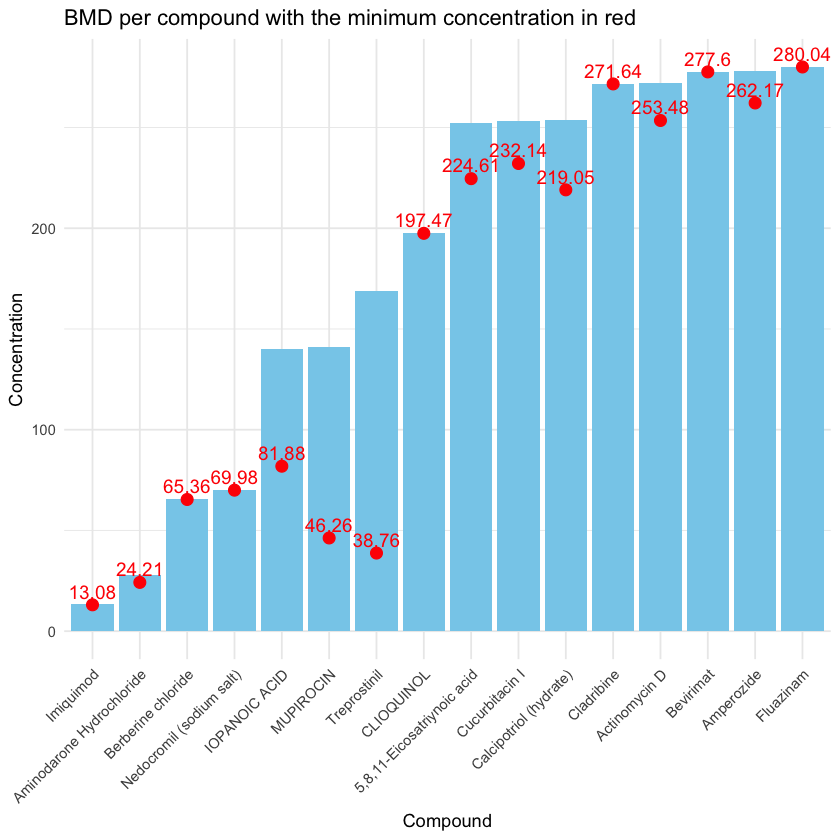

In [72]:
library(dplyr)

## Calculate the mean concentration for each compound


compound_summary <- gene_df %>%
  group_by(compound_name) %>%
  summarise(
    mean_concentration = mean(Concentration, na.rm = TRUE),  
    min_concentration = min(Concentration, na.rm = TRUE),   
    nb_proteins = n_distinct(gene_id)                   
  )


print(compound_summary)


p <- ggplot(compound_summary, aes(x = reorder(compound_name, mean_concentration), y = mean_concentration)) +
  geom_col(fill = "skyblue") + 
  geom_point(aes(y = min_concentration), color = "red", size = 3) +  
  geom_text(aes(y = min_concentration, label = round(min_concentration, 2)), 
            color = "red", vjust = -0.5, size = 4) + 
  #geom_text(aes(label = nb_proteins, y = mean_concentration + 5), size = 5, vjust = 0) +  
  labs(title = "BMD per compound with the minimum concentration in red",
       x = "Compound",
       y = "Concentration") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))  # Rotation des labels des composés

print(p)